# Brainwave Service Upload
This Notebook is intended to simplify the training / upload process by splitting the two steps into two separate notebooks. In particular, this Notebook is for uploading a previously-trained model to the cloud, and doesn't contain any training code. It does have some sanity check code to ensure you're loading in the right model, before actually uploading it.

Even though these first few cells are repeated in the training Notebooks, it is necessary here since we still must set up the environment to load the model into memory.

In [3]:
import os,sys
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
import tensorflow as tf
import numpy as np
from keras import backend as K
import tables
from tensorflow.python.client import device_lib
device_lib.list_local_devices()
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [4]:
# These directories were chosen because they write the data to local disk, which will have the fastest access time
# of our various storage options.
custom_weights_dir = os.path.expanduser("../weights-floatingpoint-224x224-fixval-best/")
custom_weights_dir_q = os.path.expanduser("../weights-quantized-224x224-fixval-best/")
saved_model_dir = os.path.expanduser("../machinelearningnotebooks/models/")
results_dir = os.path.expanduser("../results-quantized-224x224-fixval/")

## Prepare Data
Load the files we are going to use for training and testing. The public Top dataset consists of image formatted data, but our data has been preprocessed into a raw form. You will need to edit the paths as necessary.

In [3]:
from utils import normalize_and_rgb, image_with_label, count_events

In [4]:
import glob
# for 64x64:
#datadir = "../data/"
# for 224x224:
datadir = "../../converted/rotation_224_v1/"
data_size = 224 #image width/height
n_train_file = 122
n_test_file = 41
n_val_file = 41

train_files = glob.glob(os.path.join(datadir, 'train_file_*'))
test_files = glob.glob(os.path.join(datadir, 'test_file_*'))
val_files = glob.glob(os.path.join(datadir, 'val_file_*'))
#train_files = train_files[:n_train_file]
#test_files = test_files[:n_test_file]
#val_files = val_files[:n_val_file]

n_train_events = count_events(train_files)
n_test_events = count_events(test_files)
n_val_events = count_events(val_files)

print("n_train_events =", n_train_events)
print("n_test_events =", n_test_events)
print("n_val_events =", n_val_events)

n_train_events = 1211000
n_test_events = 404000
n_val_events = 403000


## Construct Model
We use ResNet50 for the featuirzer and build our own classifier using Keras layers. We train the featurizer and the classifier as one model. The weights trained on ImageNet are used as the starting point for the retraining of our featurizer. The weights are loaded from tensorflow checkpoint files.

Before passing image dataset to the ResNet50 featurizer, we need to preprocess the input file to get it into the form expected by ResNet50. ResNet50 expects float tensors representing the images in BGR, channel last order. Given that our images are greyscale, this isn't relevant to us, as we will simply be copying the data in place.

In [5]:
from utils import preprocess_images

We use Keras layer APIs to construct the classifier. Because we're using the tensorflow backend, we can train this classifier in one session with our Resnet50 model.

In [6]:
from utils import construct_classifier

Now every component of the model is defined, we can construct the model. Constructing the model with the project brainwave models is two steps - first we import the graph definition, then we restore the weights of the model into a tensorflow session. Because the quantized graph defintion and the float32 graph defintion share the same node names in the graph definitions, we can initally train the weights in float32, and then reload them with the quantized operations (which take longer) to fine-tune the model.

In [7]:
from utils import construct_model

## Load And Check The Model
If you already have a trained up, quantized model and don't want to train it any further before uploading it to the Azure server, run this cell. It will load the model and its weights into ram without applying any gradient descents. It will then perform a quick sanity check to ensure the loaded model is the one expected by passing the test images through it.

In [ ]:
from utils import chunks, test_model

tf.reset_default_graph()
sess = tf.Session(graph=tf.get_default_graph())

with sess.as_default():
    print("Testing trained model with quantization")
    in_images, image_tensors, features, preds, quantized_featurizer, classifier = construct_model(quantized=True, saved_model_dir=saved_model_dir, 
                                                                                                  starting_weights_directory=custom_weights_dir_q, 
                                                                                                  is_training=False, 
                                                                                                  size=data_size)
    loss, accuracy, auc, preds_test, test_labels = test_model(preds, in_images, test_files[:1])
    print("Accuracy:", accuracy, ", Area under ROC curve:", auc)

## Just Load The Model
If you already have a trained up, quantized model and don't want to train it any further before uploading it to the Azure server, run this cell. It will load the model and its weights into ram without applying any gradient descents. 

In [8]:
tf.reset_default_graph()
sess = tf.Session(graph=tf.get_default_graph())

with sess.as_default():
    print("Loading quantized model")
    in_images, image_tensors, features, preds, quantized_featurizer, classifier = construct_model(quantized=True, 
                                                                                                  saved_model_dir=saved_model_dir, 
                                                                                                  starting_weights_directory=custom_weights_dir_q, 
                                                                                                  is_training=False, 
                                                                                                  size=data_size)

Loading quantized model
INFO:tensorflow:Restoring parameters from ../weights-quantized-224x224-fixval-best/resnet50_bw
loading classifier weights from ../weights-quantized-224x224-fixval-best//class_weights.h5


## Service Definition
Like in the QuickStart notebook our service definition pipeline consists of three stages.

In [13]:
from azureml.contrib.brainwave.pipeline import ModelDefinition, TensorflowStage, BrainWaveStage

model_def_path = os.path.join(saved_model_dir, 'model_def.zip')

model_def = ModelDefinition()
#model_def.pipeline.append(TensorflowStage(sess, in_images, image_tensors)) # don't need this for 224x224 (no preprocessing)
model_def.pipeline.append(BrainWaveStage(sess, quantized_featurizer))
#model_def.pipeline.append(TensorflowStage(sess, features, preds)) # comment this out to get the features
model_def.save(model_def_path)
print(model_def_path)

INFO:tensorflow:Restoring parameters from ../weights-quantized-224x224-fixval-best/resnet50_bw
../machinelearningnotebooks/models/model_def.zip


## Deploy
Go to our GitHub repo "docs" folder to learn how to create a Model Management Account and find the required information below.

In [ ]:
import os

subscription_id = os.environ.get("SUBSCRIPTION_ID", "80defacd-509e-410c-9812-6e52ed6a0016")
resource_group = os.environ.get("RESOURCE_GROUP", "CMS_FPGA_Resources")
workspace_name = os.environ.get("WORKSPACE_NAME", "Fermilab")
from azureml.core import Workspace

try:
   ws = Workspace(subscription_id = subscription_id, resource_group = resource_group, workspace_name = workspace_name)
   ws.write_config()
   print('Workspace configuration succeeded. You are all set!')
except:
   print('Workspace not found. Run the cells below.')

In [9]:
from azureml.core import Workspace

ws = Workspace.from_config()
print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep = '\n')

Found the config file in: /home/jduarte/MachineLearningNotebooks/project-brainwave/aml_config/config.json
Fermilab
CMS_FPGA_Resources
eastus2
80defacd-509e-410c-9812-6e52ed6a0016


The first time the code below runs it will create a new service running your model. If you want to change the model you can make changes above in this notebook and save a new service definition. Then this code will update the running service in place to run the new model.

In [14]:
from azureml.core.model import Model
from azureml.core.image import Image
from azureml.core.webservice import Webservice
from azureml.contrib.brainwave import BrainwaveWebservice, BrainwaveImage
from azureml.exceptions import WebserviceException

model_name = "top-transfer-resnet50-model"
image_name = "top-transfer-resnet50-image"
service_name = "modelbuild-service-8"

registered_model = Model.register(ws, model_def_path, model_name)

image_config = BrainwaveImage.image_configuration()
deployment_config = BrainwaveWebservice.deploy_configuration()
    
try:
    service = Webservice(ws, service_name)
    service.delete()
    service = Webservice.deploy_from_model(ws, service_name, [registered_model], image_config, deployment_config)
    service.wait_for_deployment(True)
except WebserviceException:
    service = Webservice.deploy_from_model(ws, service_name, [registered_model], image_config, deployment_config)
    service.wait_for_deployment(True)

Registering model top-transfer-resnet50-model
Creating image
Image creation operation finished for image modelbuild-service-8:1, operation "Succeeded"
Creating service
Running..................................
SucceededFPGA service creation operation finished, operation "Succeeded"


The service is now running in Azure and ready to serve requests. We can check the address and port.

In [10]:
from azureml.core.webservice import Webservice
service_name = "modelbuild-service-8"
service = Webservice(ws, service_name)
print(service.ip_address + ':' + str(service.port))

13.92.226.231:80


## Client
There is a simple test client at amlrealtimeai.PredictionClient which can be used for testing. We'll use this client to score an image with our new service.

In [11]:
from azureml.contrib.brainwave.client import PredictionClient
client = PredictionClient(service.ip_address, service.port)

## Request
Let's see how our service does on a few images. It may get a few wrong.

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from tqdm import tqdm
from utils import chunks

chunk_size = 1  # Brainwave only processes one request at a time
n_test_events = count_events(test_files)
#n_test_events = count_events(val_files)
#n_test_events = count_events(train_files[:41])
chunk_num = int(n_test_events/chunk_size)+1

y_true = np.zeros((n_test_events,2))
y_feat = np.zeros((n_test_events,1,1,2048))
y_pred = np.zeros((n_test_events,2))

i = 0
for img_chunk, label_chunk, real_chunk_size in tqdm(chunks(test_files, chunk_size, max_q_size=1, shuffle=False), total=chunk_num):
    results = client.score_numpy_array(img_chunk)
    y_feat[i,:] = results
    y_pred[i,:] = classifier.predict(results.reshape(1,1,1,2048))[0,:]
    y_true[i,:] = label_chunk
    i+=1

In [ ]:
# Call the save results utility.
from utils import save_results

accuracy = accuracy_score(y_true[:,0], y_pred[:,0]>0.5)
auc = roc_auc_score(y_true, y_pred)
save_results(results_dir, 'b', accuracy, y_true, y_pred, y_feat)

print("Accuracy:", accuracy, "AUC:", auc)

## Plot results
If results exist for floating point training, quantization, fine tuning, and Brainwave, this should run without issues. If you have fewer, go to utils.py and comment out the irrelevant lines.

Floating point 0.9008886138613862 0.9796892626772323 0.300000989677662 670.8106312292358
Quantized      0.8413019801980198 0.9754306154368404 0.30008511227893075 414.60780287474336
Quantized, f.t. 0.9295990099009901 0.9824656282917309 0.29999604128935203 970.7403846153848
Brainwave 0.9257178217821782 0.9820568939146355 0.30015438971526975 934.787037037037
Brainwave, f.t. 0.934829207920792 0.9830090974128831 0.29999109290104214 999.5742574257426


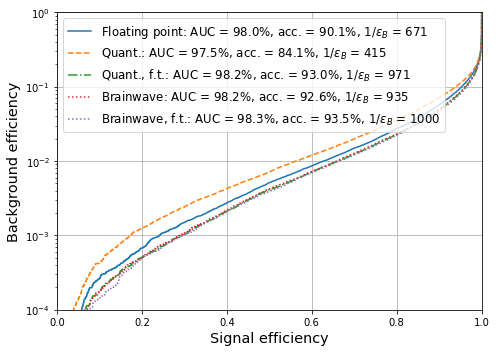

In [5]:
from utils import plot_results
%matplotlib inline
plot_results(results_dir)

## Cleanup
Run the cell below to delete your service.

In [11]:
service.delete()

Running..................................
Succeeded